In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
import warnings
warnings.filterwarnings('ignore')  #사이킷런 1.2 부터는 보스턴 주택가격 데이터가 없어진다는 warning 메시지 출력 제거
%matplotlib inline

# boston 데이타셋 로드
boston = load_boston()

# boston 데이타셋 DataFrame 변환 
bostonDF = pd.DataFrame(boston.data , columns = boston.feature_names)

# boston dataset의 target array는 주택 가격임. 이를 PRICE 컬럼으로 DataFrame에 추가함. 
bostonDF['PRICE'] = boston.target
print('Boston 데이타셋 크기 :',bostonDF.shape)
bostonDF.head()

Boston 데이타셋 크기 : (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


- CRIM: 지역별 범죄 발생률
- ZN: 25,000평방피트를 초과하는 거주 지역의 비율
- NDUS: 비상업 지역 넓이 비율
- CHAS: 찰스강에 대한 더미 변수(강의 경계에 위치한 경우는 1, 아니면 0)
- NOX: 일산화질소 농도
- RM: 거주할 수 있는 방 개수
- AGE: 1940년 이전에 건축된 소유 주택의 비율
- DIS: 5개 주요 고용센터까지의 가중 거리
- RAD: 고속도로 접근 용이도
- TAX: 10,000달러당 재산세율
- PTRATIO: 지역의 교사와 학생 수 비율
- B: 지역의 흑인 거주 비율
- LSTAT: 하위 계층의 비율
- MEDV: 본인 소유의 주택 가격(중앙값)

* 각 컬럼별로 주택가격에 미치는 영향도를 조사

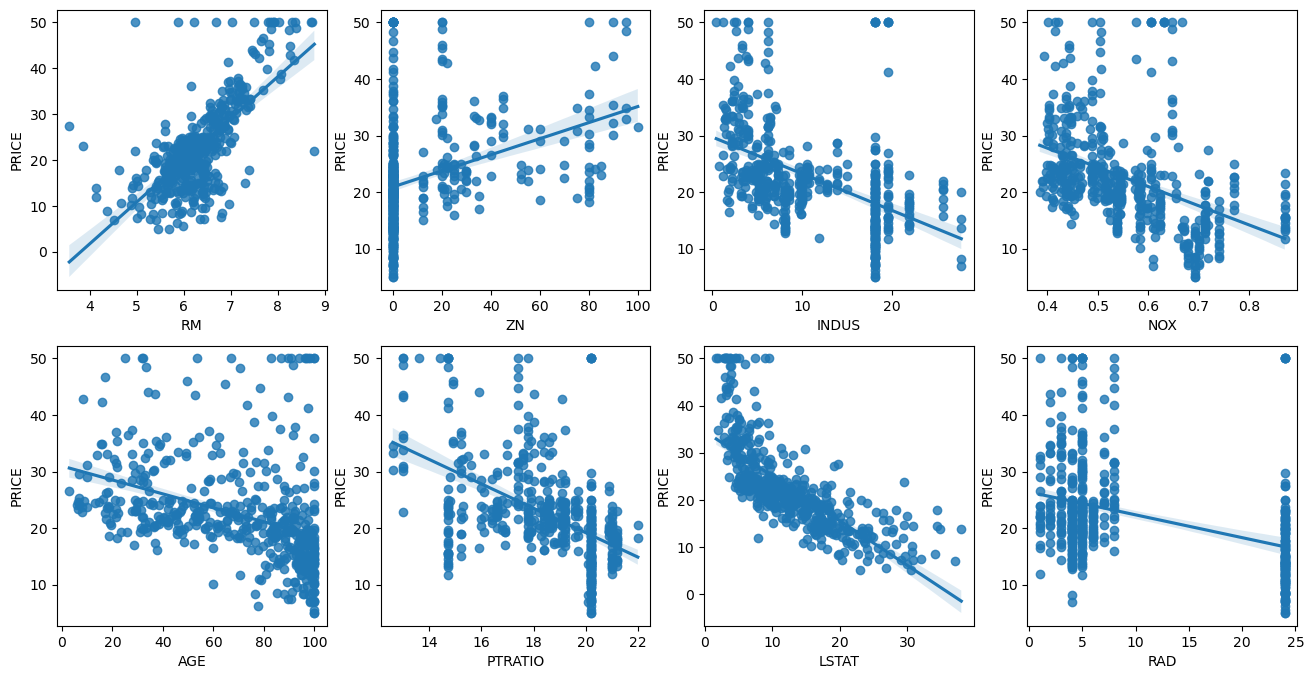

In [2]:
# 2개의 행과 4개의 열을 가진 subplots를 이용. axs는 4x2개의 ax를 가짐.
fig, axs = plt.subplots(figsize=(16,8) , ncols=4 , nrows=2)
lm_features = ['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD']
for i , feature in enumerate(lm_features):
    row = int(i/4)
    col = i%4
    # 시본의 regplot을 이용해 산점도와 선형 회귀 직선을 함께 표현
    sns.regplot(x=feature , y='PRICE',data=bostonDF , ax=axs[row][col])

fig1 = plt.gcf()
fig1.savefig('p322_boston.tif', format='tif', dpi=300, bbox_inches='tight')

* 학습과 테스트 데이터 세트로 분리

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)

X_train , X_test , y_train , y_test = train_test_split(X_data , y_target ,test_size=0.3, random_state=156)


## 선형회귀(LinearRegression)

* 학습/예측/평가 수행

In [4]:
# Linear Regression OLS로 학습/예측/평가 수행. 
lr = LinearRegression()
lr.fit(X_train ,y_train )
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(mse , rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE : 17.297 , RMSE : 4.159
Variance score : 0.757


In [5]:
print('절편 값:',lr.intercept_)
print('회귀 계수값:', np.round(lr.coef_, 1))

절편 값: 40.99559517216412
회귀 계수값: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


coef_ 속성은 회귀 계수 값만 가지고 있으므로 이를 피처별 회귀 계수 값으로 다시 매핑

In [6]:
# 회귀 계수를 큰 값 순으로 정렬하기 위해 Series로 생성. index가 칼럼명에 유의
coeff = pd.Series(data=np.round(lr.coef_, 1), index=X_data.columns )
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
AGE         0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

* 교차검증

In [7]:
from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)
lr = LinearRegression()

# cross_val_score( )로 5 Fold 셋으로 MSE 를 구한 뒤 이를 기반으로 다시  RMSE 구함. 
neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# cross_val_score(scoring="neg_mean_squared_error")로 반환된 값은 모두 음수 
print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 folds 의 개별 Negative MSE scores:  [-12.46 -26.05 -33.07 -80.76 -33.31]
 5 folds 의 개별 RMSE scores :  [3.53 5.1  5.75 8.99 5.77]
 5 folds 의 평균 RMSE : 5.829 


## 릿지 회귀(Ridge)

In [8]:
# 앞의 LinearRegression예제에서 분할한 feature 데이터 셋인 X_data과 Target 데이터 셋인 Y_target 데이터셋을 그대로 이용 
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# boston 데이타셋 로드
boston = load_boston()

# boston 데이타셋 DataFrame 변환 
bostonDF = pd.DataFrame(boston.data , columns = boston.feature_names)

# boston dataset의 target array는 주택 가격임. 이를 PRICE 컬럼으로 DataFrame에 추가함. 
bostonDF['PRICE'] = boston.target

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)


ridge = Ridge(alpha = 10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)
print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 3))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores,3))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 folds 의 개별 Negative MSE scores:  [-11.422 -24.294 -28.144 -74.599 -28.517]
 5 folds 의 개별 RMSE scores :  [3.38  4.929 5.305 8.637 5.34 ]
 5 folds 의 평균 RMSE : 5.518 


* alpha값을 0 , 0.1 , 1 , 10 , 100 으로 변경하면서 RMSE 측정

In [9]:
# 릿지에 사용될 alpha 파라미터의 값을 정의
alphas = [0, 0.1, 1, 10, 100]

# alphas list 값을 반복하면서 alpha에 따른 평균 rmse를 구함.
for alpha in alphas :
    ridge = Ridge(alpha = alpha)
    
    # cross_val_score를 이용해 5 폴드의 평균 RMSE를 계산
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0} 일 때 5 folds 의 평균 RMSE : {1:.3f} '.format(alpha, avg_rmse))

alpha 0 일 때 5 folds 의 평균 RMSE : 5.829 
alpha 0.1 일 때 5 folds 의 평균 RMSE : 5.788 
alpha 1 일 때 5 folds 의 평균 RMSE : 5.653 
alpha 10 일 때 5 folds 의 평균 RMSE : 5.518 
alpha 100 일 때 5 folds 의 평균 RMSE : 5.330 


* 각 alpha에 따른 회귀 계수 값을 시각화. 각 alpha값 별로 plt.subplots로 맷플롯립 축 생성

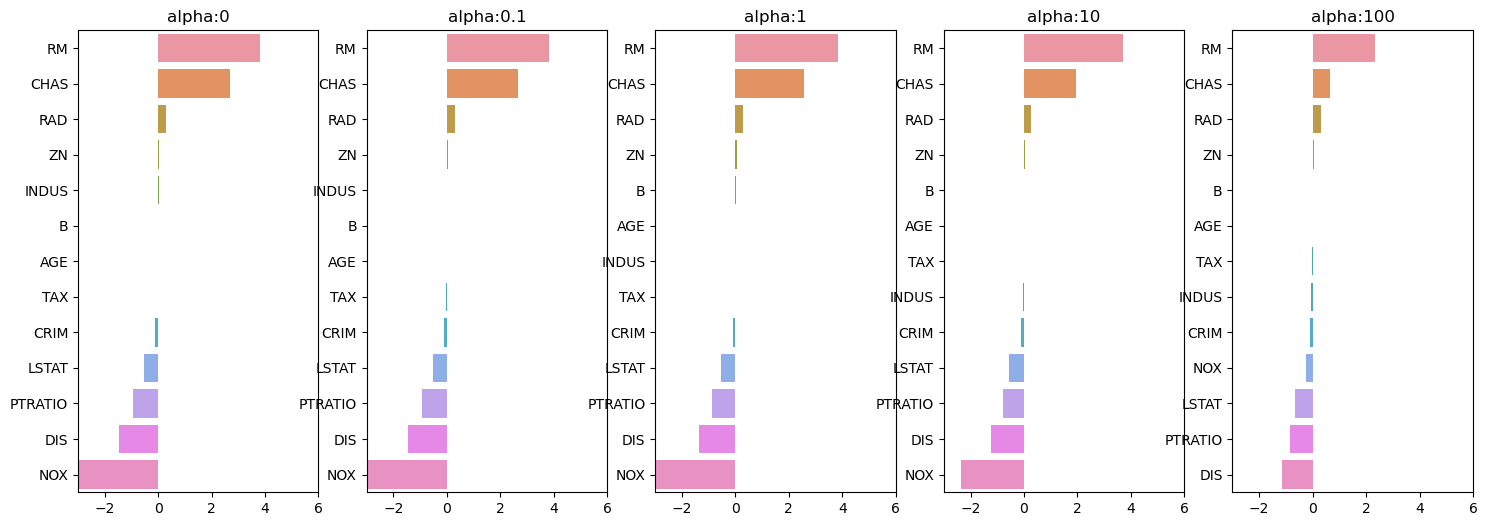

In [10]:
# 각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성  
fig , axs = plt.subplots(figsize=(18,6) , nrows=1 , ncols=5)
# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성  
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 axis의 위치 지정
for pos , alpha in enumerate(alphas) :
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_data , y_target)
    # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가.  
    coeff = pd.Series(data=ridge.coef_ , index=X_data.columns )
    colname='alpha:'+str(alpha)
    coeff_df[colname] = coeff
    # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화. 회귀 계수값이 높은 순으로 표현
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3,6)
    sns.barplot(x=coeff.values , y=coeff.index, ax=axs[pos])

# for 문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피처별 회귀 계수를 DataFrame으로 표시
plt.show()

* alpha 값에 따른 컬럼별 회귀계수 출력

In [11]:
ridge_alphas = [0 , 0.1 , 1 , 10 , 100]
sort_column = 'alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764
